In [1]:
from homography import pyrs12, spaces
import os, cv2, h5py, random, string
import numpy as np
import HandShapeAnalysis
import matplotlib.pyplot as plt

In [2]:
path = './recording/Vhdf5_20190122_161456.hdf5'

In [3]:
h5f = h5py.File(path, 'r')

In [4]:
output = os.path.splitext(path)[0]
label = np.load(output+".npy")

In [5]:
depth_frame = h5f['depth'][...]

In [6]:
pcl_center = h5f['pcl_center']
trans_matrix = h5f['trans_matrix']
analyser = HandShapeAnalysis.Depth2Finger(pcl_center, trans_matrix)
analyser.set_show(debug=False,
                   finger_point_image=True, hull_image=False, detected_defect=True, cluster_point=False, possibility_modal=False)
analyser2 = HandShapeAnalysis.Depth2Finger(pcl_center, trans_matrix)
analyser2.set_show(debug=False,
                   finger_point_image=True, hull_image=True, detected_defect=True, cluster_point=True, possibility_modal=False)



In [7]:
s = ''.join(random.choices(string.ascii_uppercase + string.digits, k=5))

In [8]:
def find_point(image, point):
    analyser2.renew_depth(depth_frame[i])
    cloud_image = np.where((analyser2.cloud[:,:,2]>0.01).reshape(analyser2.cloud.shape[0],analyser2.cloud.shape[1],1),
             analyser2.cloud, np.zeros((3,)))
    x = HandShapeAnalysis.search_closest_nonzero(point, cloud_image)
    return x
    

In [9]:
def cloudp2imagep(cloud,point):
    new = []
    for i in point:
        dist = np.linalg.norm(cloud - i,axis = 2)
        new.append(np.unravel_index(dist.argmin(), dist.shape)[::-1])#yx2xy
    return np.array(new)

# Red: point of depth image
# Yellow: both image
# blue: unmatch point

In [10]:
label.shape

(50,)

In [11]:
class Confusion(object):
    def __init__(self):
        self.TPL = []
        self.TNL = []
        self.FPL = []
        self.FNL = []
        self.detection = 0
    
    @property
    def TP(self):
        return len(self.TPL)
    @property
    def TN(self):
        return len(self.TPL)
    @property
    def FP(self):
        return len(self.FPL)
    @property
    def FN(self):
        return len(self.FNL)
    
    @property
    def recall(self):
        if (self.TP+self.FN) == 0:
            return -1
        return self.TP/(self.TP+self.FN)
    
    @property
    def precision(self):
        if (self.TP+self.FP) == 0:
            return -1
        return self.TP/(self.TP+self.FP)
    
    @property
    def Sensitivity(self):
        if (self.TP+self.FN) == 0:
            return -1
        return self.TP/(self.TP+self.FN)
    
    @property
    def Specificity(self):
        if (self.TN+self.FP) == 0:
            return -1
        return self.TN/(self.TN+self.FP)
    
    def combine(self, neighbor):
        new = Confusion()
        new.detection = self.detection + neighbor.detection
        new.TPL = [*self.TPL, *neighbor.TPL]
        new.TNL = [*self.TNL, *neighbor.TNL]
        new.FPL = [*self.FPL, *neighbor.FPL]
        new.FNL = [*self.FNL, *neighbor.FNL]
        return new
    
    def show(self):
        print("Total detection: {:d}".format(self.detection))
        print("True  Positive : {:d}".format(self.TP))## tips detected and is labeled
        print("False Positive : {:d}".format(self.FP))## tips detected and not labeled
        print("True  Negative : {:d}".format(self.FN))## tips not detected and not labeled (5-not show finger)
        print("False Negative : {:d}".format(self.FN))## tips not detected and is labeled
        print("recall : {:f}".format(self.recall))
        print("precision : {:f}".format(self.precision))
        print()

In [12]:
def Confusion_Matrix(depth_frame, label, range_, pcl_center, trans_matrix, debug = True,threathold =12):
    distance = []
    total = 0
    total_detectation = 0
    c = Confusion()
    analyser = HandShapeAnalysis.Depth2Finger(pcl_center, trans_matrix)
    analyser.set_show(debug=False,
                   finger_point_image=True, hull_image=False, detected_defect=True, cluster_point=False, possibility_modal=False)
    for i in range_:
        areas = analyser.renew_both(depth_frame[i])
        label_i = []
        impoint = []
        if(len(analyser.finger_point_cloud_coordinate)!=0):
            impoint = cloudp2imagep(analyser.cloud, analyser.finger_point_cloud_coordinate)
            total_detectation+=len(impoint)
            if debug:
                print("frame: ",i)
            label_i = label[i].tolist()

            temp_image = np.copy(analyser.D_finger_point_image)
            cv2.drawContours(temp_image, np.array(impoint).reshape(-1, 1, 2), -1, (255, 255, 0), 10)
            cv2.drawContours(temp_image, np.array(label[i]).reshape(-1, 1, 2), -1, (0, 0, 255), 8)
        if len(label_i)==0:
            print("-----------")
            print("{:d} did not label".format(i))
            print("-----------")
            continue
        while((len(label_i)>0) & (len(impoint)>0)):
            l = label_i.pop()
#             p = find_point(depth_frame[i], l)
            dis = np.linalg.norm(impoint - l,axis = 1)
            mini = np.argmin(dis)
            if debug:
                print("    distance: ", dis[mini])
            if (dis[mini]>threathold):
                c.FPL.append(len(label_i))
                reload = np.copy(analyser.D_finger_point_image)
                cv2.drawContours(reload, np.array(impoint[mini]).reshape(-1, 1, 2), -1, (255, 255, 0), 10)
                cv2.drawContours(reload, np.array(l).reshape(-1, 1, 2), -1, (0, 0, 255), 8)
                if debug:
                    print("     minimun distinct unmatch =")
                    fig = plt.figure(figsize = (12, 4))
                    ax1 = fig.add_subplot(1,2,1)
                    ax2 = fig.add_subplot(1,2,2)
                    ax1.imshow(reload, interpolation='nearest', aspect='auto')
                    ax2.imshow(temp_image, interpolation='nearest', aspect='auto')
                    plt.show()
            else:
                c.TPL.append(len(label_i))
                distance.append(dis[mini])
                impoint = np.delete(impoint, np.s_[mini], axis=0)
        if(len(impoint)>0):
            c.FNL.append(len(impoint))
            if debug:
                print("    remain(could not match any label)",len(impoint))
                cv2.drawContours(temp_image, np.array(impoint).reshape(-1, 1, 2), -1, (255, 0, 0), 8)
                plt.figure(figsize = (6, 4))
                plt.imshow(temp_image, interpolation='nearest', aspect='auto')
                plt.show()      
    c.detection = total_detectation
    return c, distance

frame:  0
    distance:  7.0
frame:  1
    distance:  4.242640687119285
    distance:  6.324555320336759
frame:  2
    distance:  5.0990195135927845
    distance:  7.280109889280518
    distance:  8.246211251235321
frame:  3
    distance:  8.06225774829855
    distance:  7.615773105863909
    distance:  7.280109889280518
    distance:  4.47213595499958
frame:  4
    distance:  7.0710678118654755
    distance:  3.1622776601683795
    distance:  5.656854249492381
    distance:  7.280109889280518
    distance:  4.0
frame:  5
    distance:  3.1622776601683795
frame:  6
    distance:  8.06225774829855
    distance:  3.605551275463989
frame:  7
    distance:  5.0
    distance:  5.0
    distance:  5.385164807134504
frame:  8
    distance:  10.0
    distance:  5.0
    distance:  5.830951894845301
    distance:  4.123105625617661
frame:  9
    distance:  4.47213595499958
    distance:  6.4031242374328485
    distance:  7.280109889280518
    distance:  4.0
    distance:  5.0990195135927845
frame

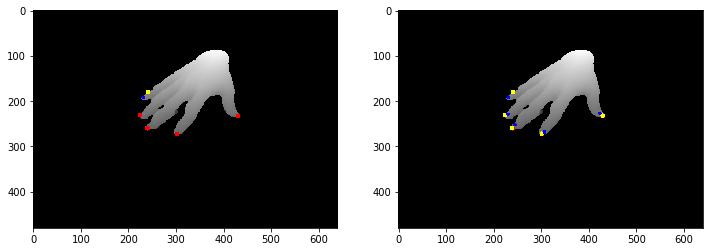

    remain(could not match any label) 1


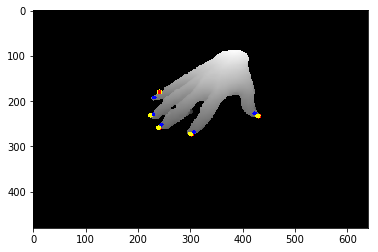

frame:  30
    distance:  4.242640687119285
    remain(could not match any label) 1


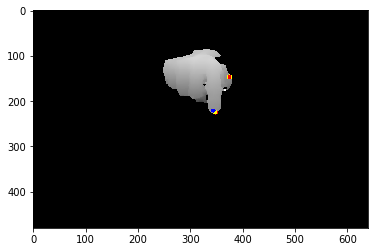

frame:  31
    distance:  6.324555320336759
    distance:  4.47213595499958
frame:  32
    distance:  6.324555320336759
    distance:  5.656854249492381
    distance:  6.0
frame:  33
    distance:  6.082762530298219
    distance:  6.708203932499369
    distance:  6.708203932499369
    distance:  5.0
frame:  34
    distance:  6.324555320336759
    distance:  3.1622776601683795
    distance:  5.0
    distance:  5.830951894845301
    distance:  4.0
frame:  35
    distance:  4.123105625617661
frame:  36
    distance:  8.0
    distance:  9.433981132056603
frame:  37
    distance:  6.082762530298219
    distance:  10.0
    distance:  7.211102550927978
frame:  38
    distance:  4.123105625617661
    distance:  6.708203932499369
    distance:  7.615773105863909
    distance:  5.0
frame:  39
    distance:  4.47213595499958
    distance:  8.54400374531753
    distance:  4.242640687119285
    distance:  5.0990195135927845
    distance:  5.385164807134504
frame:  40
    distance:  4.12310562561766

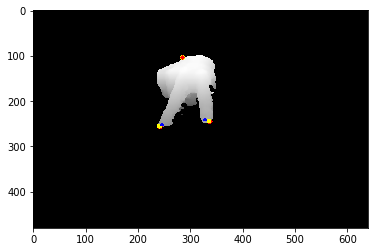

frame:  42
    distance:  8.06225774829855
    distance:  5.0
    distance:  7.0
frame:  43
    distance:  11.180339887498949
    distance:  4.123105625617661
    distance:  5.385164807134504
    distance:  4.47213595499958
frame:  44
    distance:  5.385164807134504
    distance:  5.0
    distance:  3.0
    distance:  5.656854249492381
    distance:  3.1622776601683795
frame:  45
    distance:  5.0
frame:  46
    distance:  5.385164807134504
    distance:  6.0
frame:  47
    distance:  9.848857801796104
    distance:  7.615773105863909
    distance:  6.708203932499369
frame:  48
    distance:  8.0
    distance:  5.0
    distance:  7.0
    distance:  2.23606797749979
frame:  49
    distance:  4.47213595499958
    distance:  3.605551275463989
    distance:  7.211102550927978
    distance:  8.06225774829855
    distance:  7.211102550927978


In [77]:
Matrix, distance = Confusion_Matrix(depth_frame, label,pcl_center = pcl_center, 
                                                       trans_matrix = trans_matrix, range_  =range(len(depth_frame)))

# Confusion Matrix

In [78]:
Matrix.show()

Total detection: 152
True  Positive : 149
False Positive : 1
True  Negative : 3
False Negative : 3
recall : 0.980263
precision : 0.993333



# False Positive distribution

(array([1., 0., 0., 0., 0.]),
 array([1, 2, 3, 4, 5, 6]),
 <a list of 5 Patch objects>)

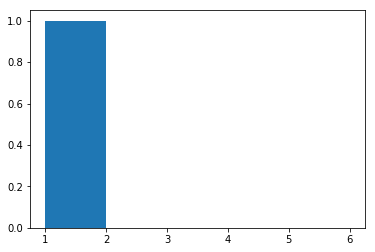

In [79]:
plt.hist(Matrix.FP,bins = [1,2,3,4,5,6])

# distribution of distance

(array([ 4., 14., 21., 30., 22., 25., 21.,  4.,  6.,  2.]),
 array([ 2.23606798,  3.13049517,  4.02492236,  4.91934955,  5.81377674,
         6.70820393,  7.60263112,  8.49705831,  9.39148551, 10.2859127 ,
        11.18033989]),
 <a list of 10 Patch objects>)

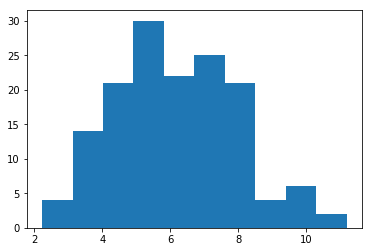

In [80]:
plt.hist(distance)

In [81]:
list(range(10,0,-1))

[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

## recall & precision, Sensitivity & Specificity

In [84]:
Matrix.show()

Total detection: 152
True  Positive : 149
False Positive : 1
True  Negative : 3
False Negative : 3
recall : 0.980263
precision : 0.993333



## Summary

In [85]:
def jobs(i):
    print(i, flush=True)
    np.copy(depth_frame)
    Matrix, _= Confusion_Matrix(depth_frame, label,pcl_center = pcl_center, 
                                trans_matrix = trans_matrix, range_  =range(len(depth_frame)),debug = False,threathold = i)
    return Matrix

In [86]:
import concurrent.futures
njob = np.arange(0.0, 20.0, 0.5)

Executor = concurrent.futures.ThreadPoolExecutor(max_workers=2)
nresults = list(Executor.map(jobs,njob))

0.0
0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
8.0
8.5
9.0
9.5
10.0
10.5
11.0
11.5
12.0
12.5
13.0
13.5
14.0
14.5
15.0
15.5
16.0
16.5
17.0
17.5
18.0
18.5
19.0
19.5


In [87]:
recall = []
precision = []
for i in nresults:
    recall.append(i.recall)
    precision.append(i.precision)

In [88]:
np.array(recall)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03846154, 0.07407407, 0.15517241, 0.26865672, 0.46428571,
       0.54639175, 0.60747664, 0.66101695, 0.72222222, 0.75      ,
       0.81118881, 0.83221477, 0.91333333, 0.92715232, 0.94078947,
       0.96052632, 0.96710526, 0.96710526, 0.98026316, 0.98026316,
       0.98026316, 0.98026316, 0.98026316, 0.98026316, 0.98026316,
       0.98026316, 0.98026316, 0.98684211, 0.98684211, 0.98684211,
       0.98684211, 0.98684211, 0.98684211, 0.98684211, 0.98684211])

In [89]:
np.array(precision)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01333333, 0.02666667, 0.06      , 0.12      , 0.26      ,
       0.35333333, 0.43333333, 0.52      , 0.60666667, 0.66      ,
       0.77333333, 0.82666667, 0.91333333, 0.93333333, 0.95333333,
       0.97333333, 0.98      , 0.98      , 0.99333333, 0.99333333,
       0.99333333, 0.99333333, 0.99333333, 0.99333333, 0.99333333,
       0.99333333, 0.99333333, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

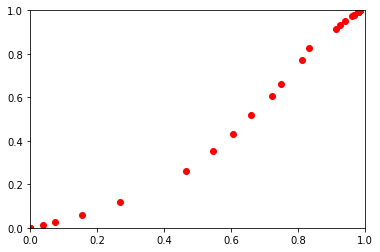

In [90]:
plt.plot(recall, precision, 'ro')
plt.axis([0, 1, 0, 1])
plt.show()

In [91]:
Sensitivity = []
Specificity = []
for i in nresults:
    Sensitivity.append(i.Sensitivity)
    Specificity.append(i.Specificity)

In [92]:
Sensitivity

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.038461538461538464,
 0.07407407407407407,
 0.15517241379310345,
 0.26865671641791045,
 0.4642857142857143,
 0.5463917525773195,
 0.6074766355140186,
 0.6610169491525424,
 0.7222222222222222,
 0.75,
 0.8111888111888111,
 0.8322147651006712,
 0.9133333333333333,
 0.9271523178807947,
 0.9407894736842105,
 0.9605263157894737,
 0.9671052631578947,
 0.9671052631578947,
 0.9802631578947368,
 0.9802631578947368,
 0.9802631578947368,
 0.9802631578947368,
 0.9802631578947368,
 0.9802631578947368,
 0.9802631578947368,
 0.9802631578947368,
 0.9802631578947368,
 0.9868421052631579,
 0.9868421052631579,
 0.9868421052631579,
 0.9868421052631579,
 0.9868421052631579,
 0.9868421052631579,
 0.9868421052631579,
 0.9868421052631579]

In [93]:
Specificity

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.013333333333333334,
 0.02666666666666667,
 0.06,
 0.12,
 0.26,
 0.35333333333333333,
 0.43333333333333335,
 0.52,
 0.6066666666666667,
 0.66,
 0.7733333333333333,
 0.8266666666666667,
 0.9133333333333333,
 0.9333333333333333,
 0.9533333333333334,
 0.9733333333333334,
 0.98,
 0.98,
 0.9933333333333333,
 0.9933333333333333,
 0.9933333333333333,
 0.9933333333333333,
 0.9933333333333333,
 0.9933333333333333,
 0.9933333333333333,
 0.9933333333333333,
 0.9933333333333333,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

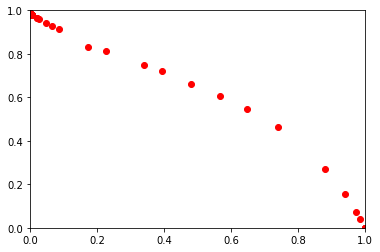

In [94]:
plt.plot(1 - np.array(Specificity),Sensitivity, 'ro')
plt.axis([0, 1, 0, 1])
plt.show()

## New Data

In [95]:
if os.name =="nt":
    !dir /b /a-d "./recording"
    data1 = './recording/ex1_20190131_170629/Vhdf5_ex1_20190131_170629.hdf5'
    data2 = './recording/ex1_20190131_171115/Vhdf5_ex1_20190131_171115.hdf5'
    data3 = './recording/ex1_20190131_173332/Vhdf5_ex1_20190131_173332.hdf5'
else:
    !ls ./recording
    data1 = '/Users/tom/Documents/multi-touch/experiement/recording/ex1_20190131_170629/Vhdf5_ex1_20190131_170629.hdf5'
    data2 = '/Users/tom/Documents/multi-touch/experiement/recording/ex1_20190131_171115/Vhdf5_ex1_20190131_171115.hdf5'
    data3 = '/Users/tom/Documents/multi-touch/experiement/recording/ex1_20190131_173332/Vhdf5_ex1_20190131_173332.hdf5'


Vhdf5_20190122_161456.hdf5
Vhdf5_20190122_161456.npy
Vhdf5_ex1_20190129_152150.hdf5


In [96]:
!ls ./recording

'ls' 不是內部或外部命令、可執行的程式或批次檔。


In [13]:
def loading(path):
    h5f = h5py.File(path, 'r')
    depth_frame = h5f['depth'][...]
    output = os.path.splitext(path)[0]
    label = np.load(output+".npy")
    pcl_center = h5f['pcl_center']
    trans_matrix = h5f['trans_matrix']
    return depth_frame, label, pcl_center, trans_matrix

def test_homography(path):
    import pptk, deproject
    h5f = h5py.File(path, 'r')
    depth_frame = h5f['depth'][...]
    pcl_center = h5f['pcl_center']
    trans_matrix = h5f['trans_matrix']
    for i in depth_frame:
        plt.imshow(i)
        plt.show()
    pptk.viewer(HandShapeAnalysis.depth2cloud(depth_frame[0], pcl_center, trans_matrix, show = False))

frame:  0
    distance:  6.708203932499369
frame:  1
    distance:  6.708203932499369
    distance:  7.280109889280518
frame:  2
    distance:  7.810249675906654
    distance:  7.280109889280518
    distance:  6.708203932499369
    remain(could not match any label) 2


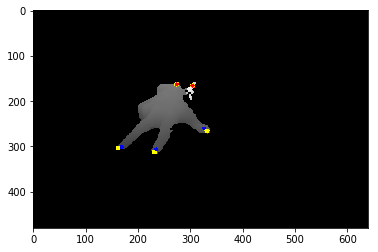

frame:  3
    distance:  6.0
    distance:  8.06225774829855
    distance:  4.242640687119285
    distance:  10.04987562112089
    remain(could not match any label) 1


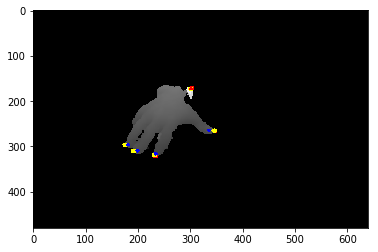

frame:  4
    distance:  3.1622776601683795
    distance:  5.0990195135927845
    distance:  7.0710678118654755
    distance:  5.830951894845301
    distance:  11.40175425099138


In [103]:
df1, l1, pc, tm = loading(data1)
Matrix1, distance1 = Confusion_Matrix(df1, l1, range(len(df1)), pcl_center = pc, trans_matrix = tm)

[-0.02538134  0.04211775  0.4859481 ] [[ 0.9928133   0.06888014  0.09786346]
 [-0.05932083 -0.57345045  0.81708974]
 [ 0.11649984 -0.8180695  -0.5631963 ]]
frame:  0
    distance:  7.810249675906654
frame:  1
    distance:  5.830951894845301
    distance:  8.602325267042627
    remain(could not match any label) 1


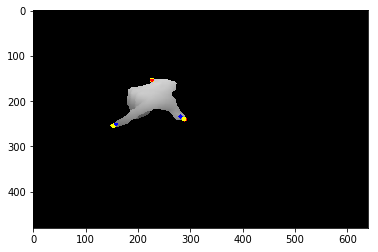

frame:  2
    distance:  9.055385138137417
    distance:  2.0
    distance:  7.0
frame:  3
-----------
3 did not label
-----------
frame:  4
    distance:  3.1622776601683795
    distance:  5.656854249492381
    distance:  7.211102550927978
    distance:  8.06225774829855
    distance:  8.246211251235321
    remain(could not match any label) 1


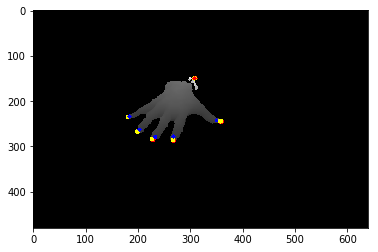

frame:  5
    distance:  2.23606797749979
    remain(could not match any label) 1


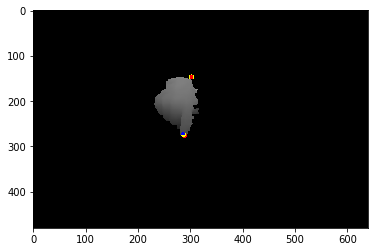

frame:  6
    distance:  11.313708498984761
    distance:  7.0710678118654755
frame:  7
    distance:  6.324555320336759
    distance:  3.1622776601683795
    distance:  8.06225774829855
frame:  8
    distance:  5.0
    distance:  3.0
    distance:  3.1622776601683795
    distance:  6.324555320336759
frame:  9
    distance:  1.4142135623730951
    distance:  3.605551275463989
    distance:  2.0
    distance:  7.810249675906654
    distance:  5.656854249492381
    remain(could not match any label) 1


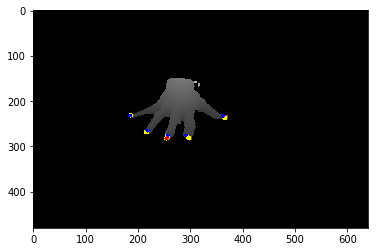

frame:  10
    distance:  3.0
frame:  11
    distance:  9.219544457292887
    distance:  5.0990195135927845
frame:  12
    distance:  3.1622776601683795
    distance:  4.0
    distance:  7.280109889280518
frame:  13
    distance:  7.0710678118654755
    distance:  5.385164807134504
    distance:  7.0710678118654755
    distance:  3.0
    remain(could not match any label) 1


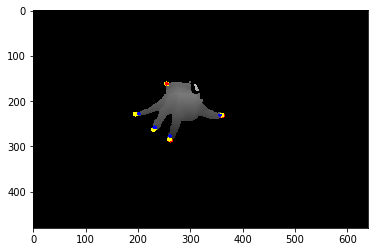

frame:  14
    distance:  3.0
    distance:  6.0
    distance:  6.708203932499369
    distance:  6.0
    distance:  6.708203932499369
frame:  15
    distance:  9.433981132056603
frame:  16
    distance:  3.605551275463989
    distance:  8.06225774829855
    remain(could not match any label) 3


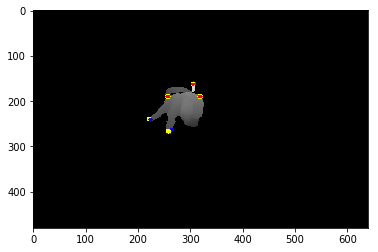

frame:  17
    distance:  3.1622776601683795
    distance:  4.123105625617661
    distance:  5.0
frame:  18
    distance:  2.23606797749979
    distance:  4.47213595499958
    distance:  6.082762530298219
    distance:  3.1622776601683795
frame:  19
    distance:  1.4142135623730951
    distance:  3.0
    distance:  5.0
    distance:  3.0
    distance:  4.242640687119285
frame:  20
    distance:  3.1622776601683795
frame:  21
    distance:  3.605551275463989
    distance:  3.605551275463989
frame:  22
    distance:  5.385164807134504
    distance:  3.605551275463989
    distance:  6.4031242374328485
    remain(could not match any label) 1


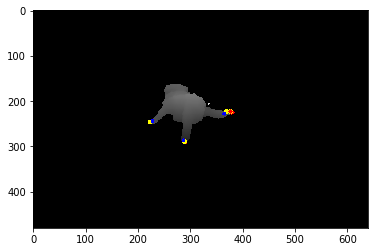

frame:  23
    distance:  4.47213595499958
    distance:  4.123105625617661
    distance:  6.4031242374328485
    distance:  3.1622776601683795
frame:  24
    distance:  4.47213595499958
    distance:  4.123105625617661
    distance:  5.385164807134504
    distance:  6.082762530298219
    distance:  7.810249675906654
frame:  25
    distance:  2.23606797749979
    remain(could not match any label) 1


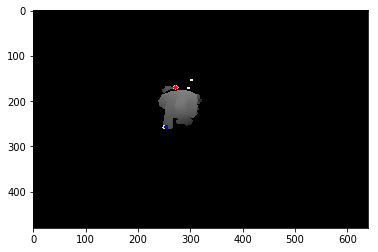

frame:  26
    distance:  4.0
    distance:  121.06609764917675
     minimun distinct unmatch =


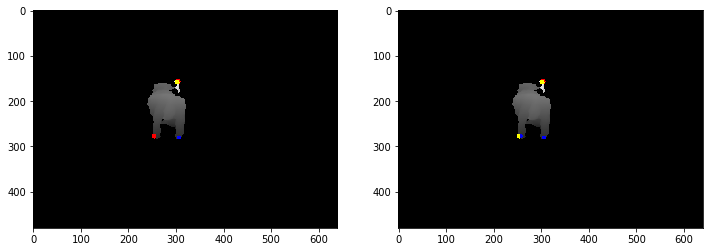

    remain(could not match any label) 1


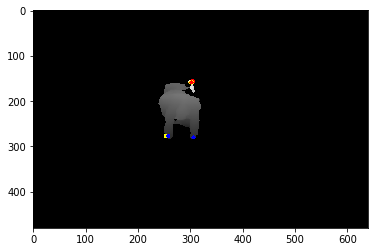

frame:  27
    distance:  5.830951894845301
    distance:  5.656854249492381
    distance:  4.123105625617661
frame:  28
    distance:  6.4031242374328485
    distance:  6.0
    distance:  4.0
    distance:  5.0
    remain(could not match any label) 1


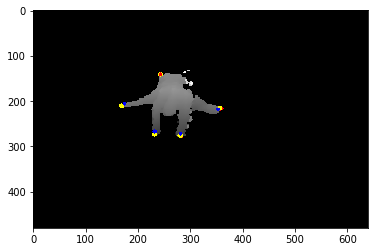

frame:  29
    distance:  5.0
    distance:  8.54400374531753
    distance:  5.656854249492381
    distance:  5.830951894845301
    distance:  5.830951894845301
    remain(could not match any label) 2


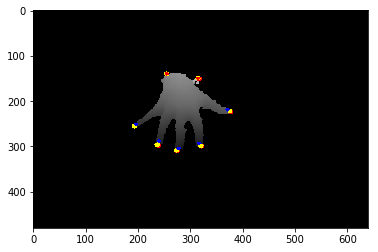

frame:  30
    distance:  6.324555320336759
frame:  31
    distance:  7.810249675906654
    distance:  7.810249675906654
frame:  32
    distance:  8.94427190999916
    distance:  6.708203932499369
    distance:  6.324555320336759
frame:  33
    distance:  7.211102550927978
    distance:  2.8284271247461903
    distance:  5.0
    distance:  6.082762530298219
    remain(could not match any label) 2


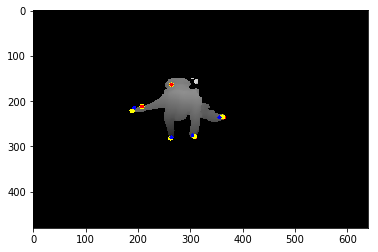

frame:  34
    distance:  4.123105625617661
    distance:  5.0
    distance:  8.94427190999916
    distance:  6.708203932499369
    distance:  5.656854249492381
    remain(could not match any label) 2


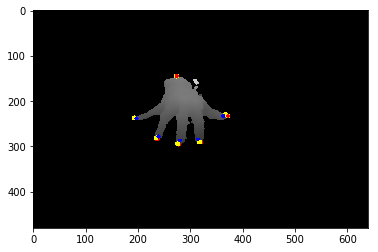

frame:  35
    distance:  4.47213595499958
    remain(could not match any label) 1


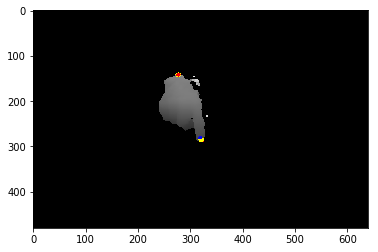

frame:  36
    distance:  7.0710678118654755
    distance:  7.0710678118654755
    remain(could not match any label) 2


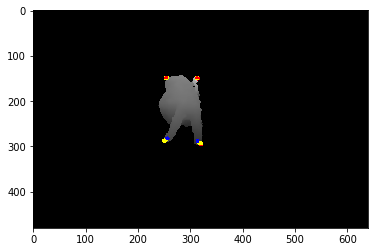

frame:  37
    distance:  8.94427190999916
    distance:  4.47213595499958
    distance:  7.0
    remain(could not match any label) 2


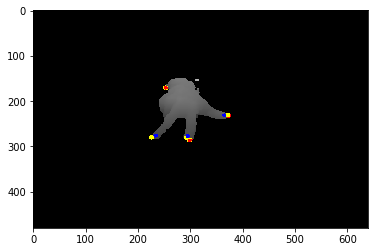

frame:  38
    distance:  5.830951894845301
    distance:  6.324555320336759
    distance:  5.0
    distance:  7.0710678118654755
    remain(could not match any label) 1


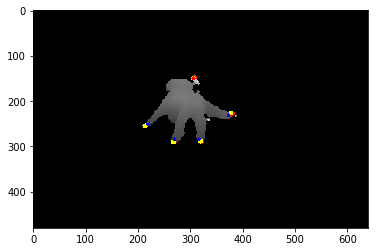

frame:  39
    distance:  5.0
    distance:  4.123105625617661
    distance:  5.0
    distance:  3.605551275463989
    distance:  7.0710678118654755
frame:  40
    distance:  7.615773105863909
    remain(could not match any label) 1


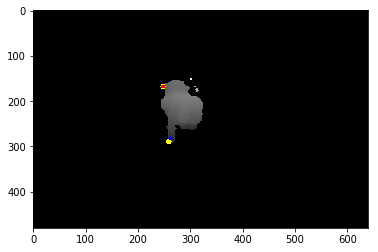

frame:  41
    distance:  7.0710678118654755
    distance:  5.656854249492381
    remain(could not match any label) 1


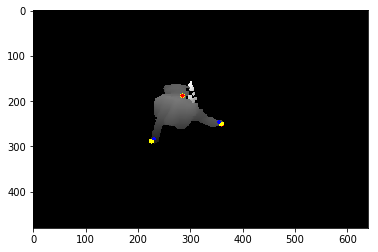

frame:  42
    distance:  6.324555320336759
    distance:  5.0
    distance:  3.1622776601683795
    remain(could not match any label) 1


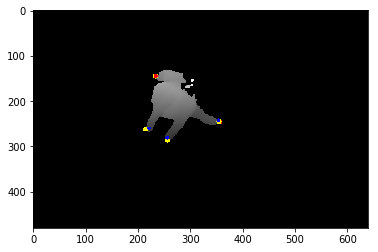

frame:  43
    distance:  5.0
    distance:  5.0990195135927845
    distance:  8.06225774829855
    distance:  7.615773105863909
    remain(could not match any label) 1


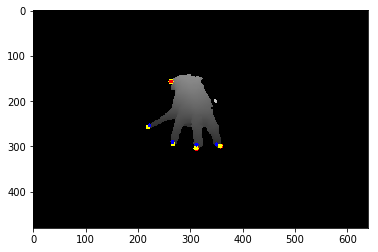

frame:  44
    distance:  4.123105625617661
    distance:  7.810249675906654
    distance:  8.0
    distance:  5.0990195135927845
    distance:  6.4031242374328485
    remain(could not match any label) 2


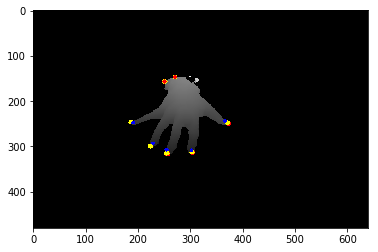

frame:  45
    distance:  8.48528137423857
    remain(could not match any label) 1


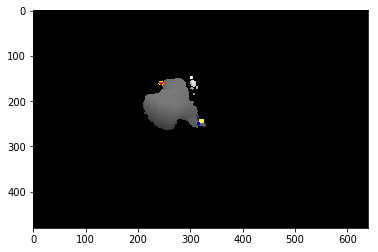

frame:  46
    distance:  10.816653826391969
    distance:  2.0
    remain(could not match any label) 1


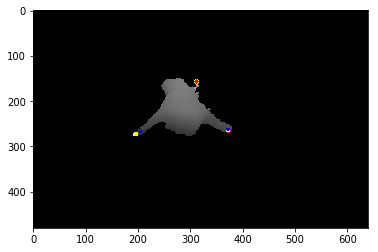

frame:  47
    distance:  6.4031242374328485
    distance:  4.0
    distance:  7.0710678118654755
    remain(could not match any label) 1


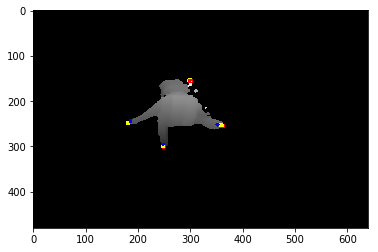

frame:  48
    distance:  7.0710678118654755
    distance:  6.324555320336759
    distance:  6.082762530298219
frame:  49
    distance:  3.1622776601683795
    distance:  3.1622776601683795
    distance:  5.0
    distance:  4.47213595499958
    distance:  6.324555320336759
    remain(could not match any label) 1


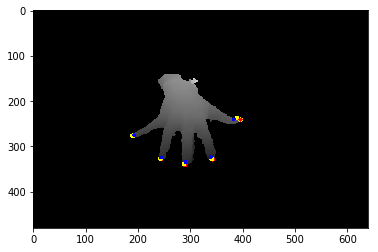

In [104]:
df1, l1, pc, tm = loading(data2)
print(pc[...], tm[...])
Matrix2, distance2 = Confusion_Matrix(df1, l1, range(len(df1)), pcl_center = pc, trans_matrix = tm)

[-0.02538134  0.04211775  0.4859481 ] [[ 0.9928133   0.06888014  0.09786346]
 [-0.05932083 -0.57345045  0.81708974]
 [ 0.11649984 -0.8180695  -0.5631963 ]]
frame:  0
    distance:  6.4031242374328485
frame:  1
    distance:  6.708203932499369
    distance:  8.06225774829855
frame:  2
    distance:  5.656854249492381
    distance:  9.055385138137417
    distance:  6.082762530298219
frame:  3
    distance:  3.605551275463989
    distance:  8.06225774829855
    distance:  7.0710678118654755
    distance:  6.324555320336759
frame:  4
    distance:  4.0
    distance:  5.656854249492381
    distance:  7.615773105863909
    distance:  5.0
    distance:  6.0
frame:  5
    distance:  5.830951894845301
    remain(could not match any label) 2


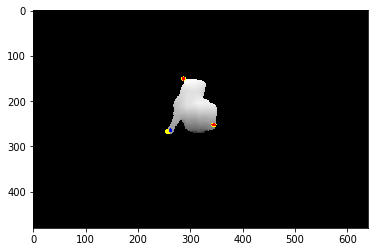

frame:  6
    distance:  4.242640687119285
    distance:  5.830951894845301
frame:  7
    distance:  5.830951894845301
    distance:  5.830951894845301
    distance:  7.0710678118654755
frame:  8
    distance:  3.605551275463989
    distance:  7.211102550927978
    distance:  5.0990195135927845
    distance:  6.324555320336759
frame:  9
    distance:  4.47213595499958
    distance:  5.830951894845301
    distance:  7.810249675906654
    distance:  7.211102550927978
    distance:  7.280109889280518
frame:  10
    distance:  5.0
    remain(could not match any label) 1


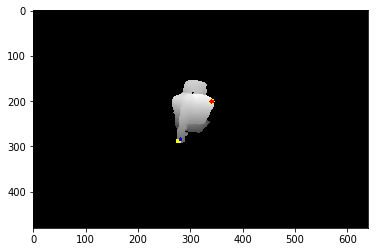

frame:  11
    distance:  6.324555320336759
    distance:  4.242640687119285
frame:  12
-----------
12 did not label
-----------
frame:  13
    distance:  4.123105625617661
    distance:  5.385164807134504
    distance:  8.246211251235321
    distance:  7.0710678118654755
frame:  14
    distance:  7.0710678118654755
    distance:  5.656854249492381
    distance:  8.54400374531753
    distance:  6.4031242374328485
    distance:  8.94427190999916
frame:  15
    distance:  6.082762530298219
frame:  16
    distance:  6.4031242374328485
    distance:  7.810249675906654
frame:  17
    distance:  5.385164807134504
    distance:  7.211102550927978
    distance:  2.23606797749979
    remain(could not match any label) 1


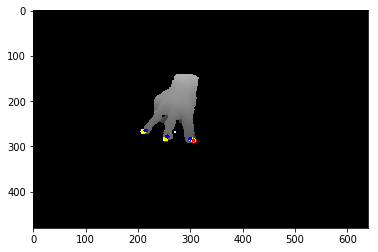

frame:  18
    distance:  5.0
    distance:  5.0
    distance:  8.246211251235321
    distance:  8.94427190999916
frame:  19
    distance:  5.385164807134504
    distance:  7.0710678118654755
    distance:  6.708203932499369
    distance:  5.0
    distance:  9.486832980505138
frame:  20
    distance:  4.0
frame:  21
    distance:  5.830951894845301
    distance:  6.4031242374328485
frame:  22
    distance:  5.656854249492381
    distance:  7.810249675906654
    distance:  2.0
    remain(could not match any label) 1


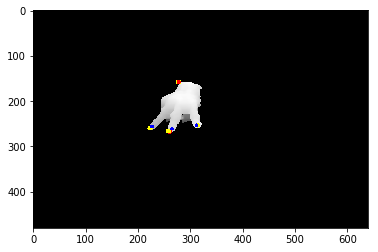

frame:  23
-----------
23 did not label
-----------
frame:  24
    distance:  1.4142135623730951
    distance:  7.0710678118654755
    distance:  7.0710678118654755
    distance:  7.280109889280518
    distance:  10.44030650891055
frame:  25
    distance:  6.708203932499369
frame:  26
    distance:  3.0
    remain(could not match any label) 2


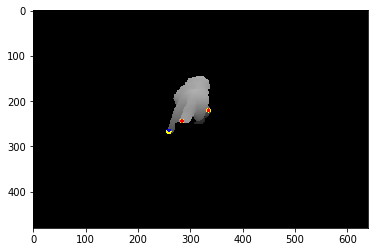

frame:  27
    distance:  6.708203932499369
    distance:  8.54400374531753
    distance:  6.4031242374328485
frame:  28
    distance:  7.280109889280518
    distance:  7.0710678118654755
    distance:  5.0990195135927845
    distance:  5.0
frame:  29
    distance:  3.605551275463989
    distance:  6.4031242374328485
    distance:  8.54400374531753
    distance:  4.47213595499958
    distance:  9.055385138137417
frame:  30
    distance:  3.1622776601683795
frame:  31
    distance:  7.615773105863909
    distance:  6.082762530298219
    remain(could not match any label) 1


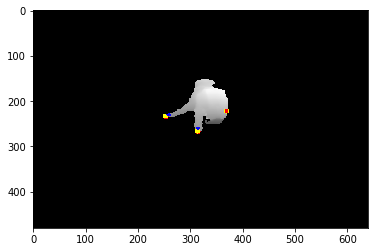

frame:  32
    distance:  7.810249675906654
    distance:  4.47213595499958
    distance:  7.615773105863909
    remain(could not match any label) 1


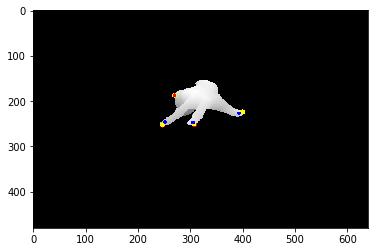

frame:  33
    distance:  2.23606797749979
    distance:  4.47213595499958
    distance:  6.324555320336759
    distance:  6.4031242374328485
frame:  34
    distance:  4.0
    distance:  5.385164807134504
    distance:  4.123105625617661
    distance:  7.810249675906654
    distance:  3.605551275463989
frame:  35
    distance:  6.082762530298219
frame:  36
    distance:  4.0
    distance:  9.219544457292887
    remain(could not match any label) 2


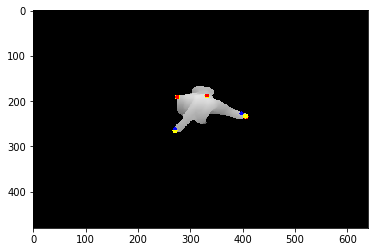

frame:  37
    distance:  6.082762530298219
    distance:  7.615773105863909
    distance:  8.94427190999916
frame:  38
    distance:  3.1622776601683795
    distance:  10.63014581273465
    distance:  8.06225774829855
    distance:  6.324555320336759
frame:  39
    distance:  5.385164807134504
    distance:  5.0990195135927845
    distance:  6.4031242374328485
    distance:  4.123105625617661
    distance:  8.48528137423857
-----------
40 did not label
-----------
frame:  41
    distance:  4.0
    distance:  7.280109889280518
frame:  42
    distance:  3.1622776601683795
    distance:  4.123105625617661
    distance:  5.385164807134504
frame:  43
    distance:  3.1622776601683795
    distance:  5.0990195135927845
    distance:  6.082762530298219
    distance:  4.47213595499958
frame:  44
    distance:  3.605551275463989
    distance:  3.605551275463989
    distance:  6.708203932499369
    distance:  4.123105625617661
    distance:  7.0710678118654755
frame:  45
    distance:  7.8102496

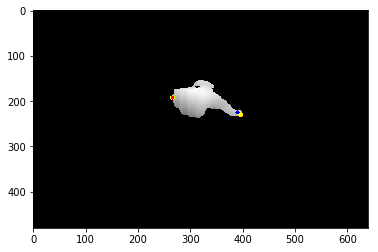

frame:  46
    distance:  3.1622776601683795
frame:  47
    distance:  4.123105625617661
    distance:  3.605551275463989
    distance:  87.09190547921202
     minimun distinct unmatch =


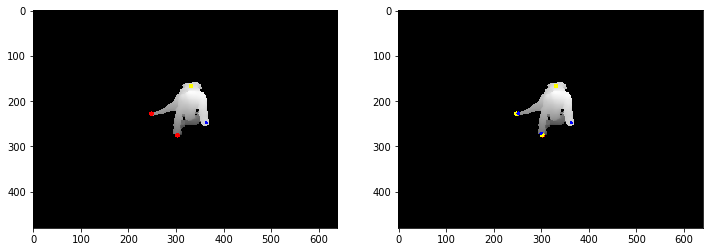

    remain(could not match any label) 1


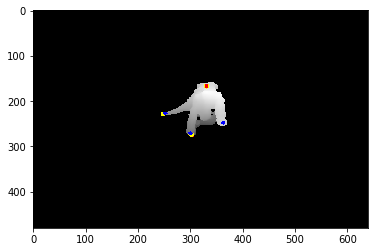

frame:  48
    distance:  2.0
    distance:  5.385164807134504
    distance:  4.0
    distance:  8.246211251235321
    remain(could not match any label) 3


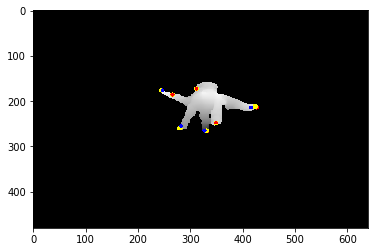

frame:  49
    distance:  2.23606797749979
    distance:  2.8284271247461903
    distance:  4.47213595499958
    distance:  5.385164807134504
    distance:  9.848857801796104


In [105]:
df1, l1, _, _ = loading(data3)
print(pc[...], tm[...])
Matrix3, distance3 = Confusion_Matrix(df1, l1, range(len(df1)), pcl_center = pc, trans_matrix = tm)

In [107]:
Mc = Matrix1.combine(Matrix2)
Mc = Mc.combine(Matrix3)

In [108]:
Mc.show()

Total detection: 364
True  Positive : 298
False Positive : 2
True  Negative : 39
False Negative : 39
recall : 0.884273
precision : 0.993333



In [109]:
print(Mc.recall)
print(Mc.precision)

0.884272997032641
0.9933333333333333


## Experiment 2

In [13]:
if os.name =="nt":
    filename = !dir /b "./recording" | findstr "ex2"
else:
    filename = !ls recording | grep ex2

In [14]:
filename

['ex2_20190131_164230', 'ex2_20190131_171522', 'ex2_20190131_173820']

In [15]:
file = []
for i in filename:
    file.append('./recording/'+i+'/Vhdf5_'+i+'.hdf5')

In [16]:
def loading_ex2(path):
    h5f = h5py.File(path, 'r')
    depth_frame = h5f['depth'][...]
    output = os.path.splitext(path)[0]
    label = np.load(output+".npy")
    pcl_center = h5f['pcl_center']
    trans_matrix = h5f['trans_matrix']
    return depth_frame, label, pcl_center, trans_matrix

frame:  0
    distance:  4.0
    distance:  5.0
    distance:  13.601470508735444
     minimun distinct unmatch =


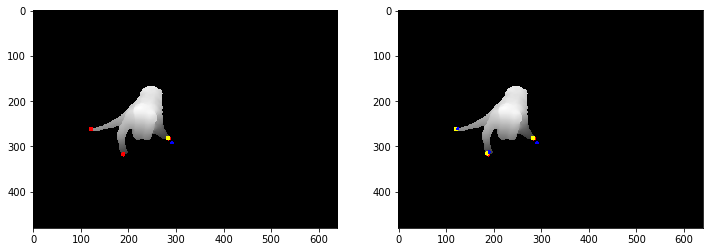

    remain(could not match any label) 1


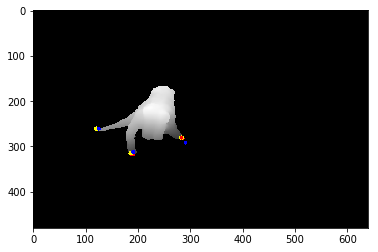

frame:  1
    distance:  5.830951894845301
frame:  2
    distance:  5.0
    distance:  33.301651610693426
     minimun distinct unmatch =


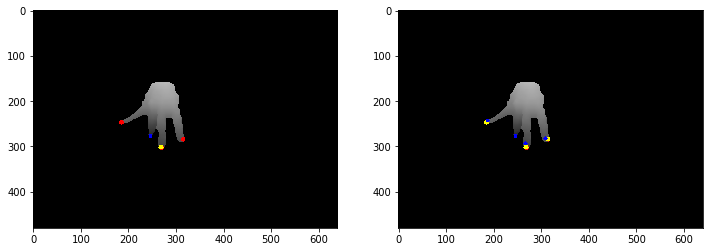

    distance:  9.055385138137417
    distance:  5.0990195135927845
frame:  3
    distance:  5.0
    distance:  5.830951894845301
    distance:  75.13321502504735
     minimun distinct unmatch =


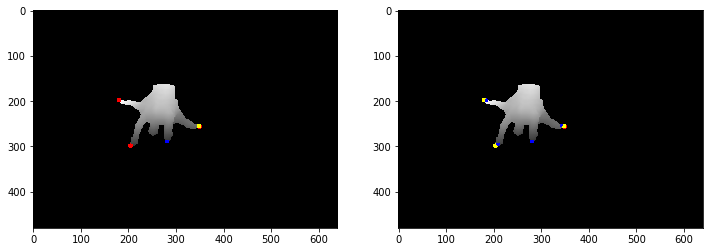

    distance:  6.324555320336759
frame:  0
    distance:  1.0
    distance:  15.033296378372908
     minimun distinct unmatch =


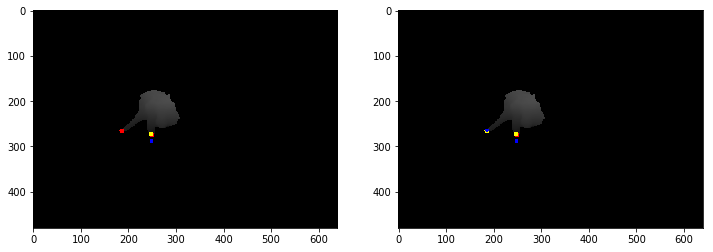

    remain(could not match any label) 1


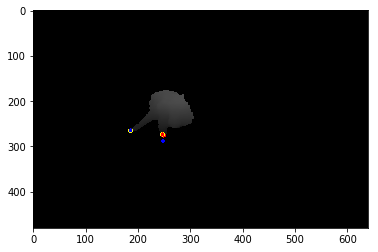

frame:  1
    distance:  16.492422502470642
     minimun distinct unmatch =


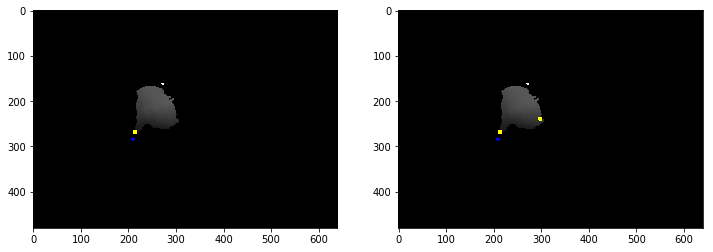

    remain(could not match any label) 2


KeyboardInterrupt: 

In [24]:
result = []
for i in file:
    df, l, pc, tm = loading(i)
    result.append(Confusion_Matrix(df, l, range(len(df)),pcl_center = pc, trans_matrix = tm))

In [116]:
x = Confusion()
for i in result:
    Matrix, distance = i
    x = x.combine(Matrix)
    Matrix.show()

Total detection: 10
True  Positive : 9
False Positive : 3
True  Negative : 1
False Negative : 1
recall : 0.900000
precision : 0.750000

Total detection: 133
True  Positive : 89
False Positive : 36
True  Negative : 31
False Negative : 31
recall : 0.741667
precision : 0.712000

Total detection: 96
True  Positive : 73
False Positive : 22
True  Negative : 11
False Negative : 11
recall : 0.869048
precision : 0.768421



## Sum up

In [118]:
x.show()

Total detection: 239
True  Positive : 171
False Positive : 61
True  Negative : 43
False Negative : 43
recall : 0.799065
precision : 0.737069



## Touching evaluation

In [17]:
import importlib
importlib.reload(HandShapeAnalysis)

<module 'HandShapeAnalysis' from 'E:\\User\\workspace\\multi-touch\\experiement\\HandShapeAnalysis.py'>

In [18]:
from keras.models import load_model
model = load_model('depth_angle_model.hdf5')

Using TensorFlow backend.


In [19]:
model._make_predict_function()

In [20]:
def loading_touch(path):
    h5f = h5py.File(path, 'r')
    depth_frame = h5f['depth'][...]
    pcl_center = h5f['pcl_center'][...]
    trans_matrix = h5f['trans_matrix'][...]
    
    output = os.path.splitext(path)[0]
    label_point = np.load(output+".npy")##auctal point
    
    directory = os.path.dirname(path)
    label_label = np.load(directory+"/show_touch_tuple.npy")##indexed finger
    
    
    new_depth_frame = []
    new_label_point = []
    label_istouch = []#boolean array of whether the label is touching
    for i in range(len(depth_frame)):
        if(len(label_point[i])!=0):
            new_depth_frame.append(depth_frame[i])
            new_label_point.append(label_point[i][label_point[i][:,0].argsort()[::-1]])
            new = []
            for index in label_label[i][0]:
                new.append(index in label_label[i][1])
            label_istouch.append(new)
    h5f.close()
    
    return np.array(new_depth_frame), np.array(new_label_point), np.array(label_istouch), pcl_center, trans_matrix

In [21]:
def Confusion_Matrix_touch(analyser, depth_frame, label_label, label_istouch, range_, debug = True,threathold =12):
    total = 0
    total_detectation = 0
    tips_detection = Confusion()
    touch_detection = Confusion()
    distance = []
    for i in range_:
        areas, points = analyser.renew_both(depth_frame[i])
        
        impoint = []
        label_label_i =[]
        label_istouch_i = []
        if(len(analyser.finger_point_cloud_coordinate)!=0):
            impoint = cloudp2imagep(analyser.cloud, analyser.finger_point_cloud_coordinate)
            total_detectation+=len(impoint)
            if debug:
                print("frame: ",i)
            label_label_i = label_label[i].tolist()
            label_istouch_i = label_istouch[i]
            temp_image = np.copy(analyser.D_finger_point_image)
            cv2.drawContours(temp_image, np.array(impoint).reshape(-1, 1, 2), -1, (255, 255, 0), 10)
            cv2.drawContours(temp_image, np.array(label_label_i).reshape(-1, 1, 2), -1, (0, 0, 255), 8)

            if (len(label_label_i)==0) & debug:
                print("-----------")
                print("{:d} did not label".format(i))
                print("-----------")
                continue
        while((len(label_label_i)>0) & (len(impoint)>0)):
            ll = label_label_i.pop()
            if(len(label_istouch_i)!=0):
                lt = label_istouch_i.pop()
#             p = find_point(depth_frame[i], l)
            dis = np.linalg.norm(impoint - ll,axis = 1)
            mini = np.argmin(dis)
            if debug:
                print("    distance: ", dis[mini])
            if (dis[mini]>threathold):
                tips_detection.FPL.append(len(ll))
                reload = np.copy(analyser.D_finger_point_image)
                cv2.drawContours(temp_image, np.array(impoint[mini]).reshape(-1, 1, 2), -1, (255, 255, 0), 10)
                cv2.drawContours(temp_image, np.array(ll).reshape(-1, 1, 2), -1, (0, 0, 255), 8)
                if debug:
                    print("     minimun distinct unmatch =")
                    fig = plt.figure(figsize = (12, 4))
                    ax1 = fig.add_subplot(1,2,1)
                    ax2 = fig.add_subplot(1,2,2)
                    ax1.imshow(reload, interpolation='nearest', aspect='auto')
                    ax2.imshow(temp_image, interpolation='nearest', aspect='auto')
                    plt.show()
            else:
                tips_detection.TPL.append(len(ll))
                distance.append(dis[mini])
                if(lt is not None):
                    x_predicts = analyser.predict_return(np.array([areas[mini]]))
                    y_predict = model.predict(x_predicts)
                    if(lt):
                        if(y_predict[0][0]==1):
                            touch_detection.TPL.append(1)
                        else:
                            touch_detection.FPL.append(1)
                    else:
                        if(y_predict[0][0]!=1):
                            touch_detection.TNL.append(1)
                        else:
                            touch_detection.FNL.append(1)

                    impoint = np.delete(impoint, np.s_[mini], axis=0)
                    areas = np.delete(areas, np.s_[mini], axis=0)
            ll = None
            lt = None
        if(len(impoint)>0):
            tips_detection.FNL.append(len(impoint))
            if debug:
                print("    remain(could not match any label)",len(impoint))
                cv2.drawContours(temp_image, np.array(impoint).reshape(-1, 1, 2), -1, (255, 0, 0), 8)
                plt.figure(figsize = (6, 4))
                plt.imshow(temp_image, interpolation='nearest', aspect='auto')
                plt.show()
    tips_detection.detection = total_detectation
    return tips_detection, touch_detection, distance

In [22]:
print(file)

['./recording/ex2_20190131_164230/Vhdf5_ex2_20190131_164230.hdf5', './recording/ex2_20190131_171522/Vhdf5_ex2_20190131_171522.hdf5', './recording/ex2_20190131_173820/Vhdf5_ex2_20190131_173820.hdf5']


In [23]:
def experiment_package(parameter):
    df, lp, lt, pc, tm = parameter
    tips_detection, touch_detection, distance = Confusion_Matrix_touch(df, lp, lt, range(len(df)), 
                                                          pcl_center = pc, trans_matrix = tm, debug = False)

In [24]:
def evaluate_list_file(file):
    result = []
    for i in file:
        df, lp, lt, pc, tm = loading_touch(i)
        analyser = HandShapeAnalysis.Depth2Finger(pc, tm)
        analyser.set_show(debug=False,finger_point_image=True, hull_image=False, detected_defect=True, cluster_point=False, possibility_modal=False)
        tips_detection, touch_detection, distance = Confusion_Matrix_touch(analyser, df, lp, lt, range(len(df)), debug = False)
        result.append((tips_detection, touch_detection))
    
    tips_detection = Confusion()
    touch_detection = Confusion()
    for i in result:
        tips_detection = tips_detection.combine(i[0])
        touch_detection = touch_detection.combine(i[1])
    return tips_detection, touch_detection, result

In [25]:
tips_detection, touch_detection, result = evaluate_list_file(file)

E:\ProgramFiles\anaconda\lib\site-packages\numpy\lib\histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [26]:
tips_detection.show()

Total detection: 230
True  Positive : 171
False Positive : 62
True  Negative : 46
False Negative : 46
recall : 0.788018
precision : 0.733906



In [27]:
touch_detection.show()

Total detection: 0
True  Positive : 25
False Positive : 31
True  Negative : 10
False Negative : 10
recall : 0.714286
precision : 0.446429



## Parameter searching

Program

parameter = []
for angel in range(40,70,10):
    for cloud_min in np.arange(0.005, 0.02, 0.005):
        for combine_minimun_distance in np.arange(0.01, 0.5, 0.005):
            for circling_distance in np.arange(0.01, 0.05, 0.005):
                for analysis_image_kernal in kernal:
                    for cluster_threshold_ in range(10,40,10):
                        parameter.append({"angel": angel, "cloud_min":cloud_min,
                                          "combine_minimun_distance":combine_minimun_distance,
                                          "circling_distance":circling_distance, 
                                          "analysis_image_kernal":analysis_image_kernal,
                                         "cluster_threshold_":cluster_threshold_})

In [26]:
kernal =[]
for i in range(2,4):
    kernal.append(cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(i,i)))
    kernal.append(cv2.getStructuringElement(cv2.MORPH_CROSS,(i,i)))
    kernal.append(cv2.getStructuringElement(cv2.MORPH_RECT,(i,i)))

In [27]:
## Brute-force wouldn't work
len(range(20,70))* len(np.arange(0.00, 0.02, 0.001)) * len(np.arange(0.01, 0.1, 0.001)) *len(np.arange(0.01, 0.05, 0.001)) * len(kernal)*len(range(5,40))

764400000

In [52]:
parameter = []
for angel in range(40,70,10):
    for cloud_min in np.arange(0.005, 0.02, 0.005):
        for combine_minimun_distance in np.arange(0.01, 0.05, 0.005):
            for analysis_image_kernal in kernal:
                for cluster_threshold_ in range(10,40,10):
                    parameter.append({"angel": angel, "cloud_min":cloud_min,
                                "combine_minimun_distance":combine_minimun_distance,
                                  "analysis_image_kernal":analysis_image_kernal,
                                      "cluster_threshold_":cluster_threshold_
                                 })

In [29]:
def job_parameter(jobs):
    result = []
    file, parameters = jobs
    for i in range(len(parameters)):
        tips_d_sum = Confusion()
        touch_d_sum = Confusion()
        for f in file:
            df, lp, lt, pc, tm = loading_touch(f)
            analyser = HandShapeAnalysis.Depth2Finger(pc, tm)
            analyser.set_show(debug=False,finger_point_image=True, hull_image=False, detected_defect=True, cluster_point=False, possibility_modal=False)
            if 'angel' in parameter[i].keys():
                analyser.angel = parameter[i]['angel']
            if 'cloud_min' in parameter[i].keys():
                analyser.cloud_min = parameter[i]['cloud_min']
            if 'combine_minimun_distance' in parameter[i].keys():
                analyser.combine_minimun_distance = parameter[i]['combine_minimun_distance']
            if 'circling_distance' in parameter[i].keys():
                analyser.circling_distance = parameter[i]['circling_distance']
            if 'analysis_image_kernal' in parameter[i].keys():
                analyser.analysis_image_kernal = parameter[i]['analysis_image_kernal']
            if 'cluster_threshold_' in parameter[i].keys():
                analyser.cluster_threshold_ = parameter[i]['cluster_threshold_']
            tips_detection, touch_detection, _ = Confusion_Matrix_touch(analyser, df, lp, lt, range(len(df)), debug = False)
            tips_d_sum = tips_d_sum.combine(tips_detection)
            touch_d_sum = touch_d_sum.combine(touch_detection)
        result.append((parameter[i], tips_d_sum, touch_d_sum))
        print(i/len(parameters))
    return result

In [30]:
import concurrent.futures
def evaluate_parameter(file, parameter):
    first = (file,parameter[0:int((len(parameter)/2))])
    second = (file,parameter[int((len(parameter)/2)):int((len(parameter)))])
    
    Executor = concurrent.futures.ThreadPoolExecutor(max_workers=2)
    results = list(Executor.map(job_parameter,[first,second]))
    return results

In [54]:
len(parameter)

1296

In [57]:
results = evaluate_parameter(file, parameter)

0.0
0.0
0.0015432098765432098
0.0015432098765432098
0.0030864197530864196
0.0030864197530864196
0.004629629629629629
0.004629629629629629
0.006172839506172839
0.006172839506172839
0.007716049382716049
0.007716049382716049
0.009259259259259259
0.009259259259259259
0.010802469135802469
0.012345679012345678
0.010802469135802469
0.013888888888888888
0.012345679012345678
0.015432098765432098
0.013888888888888888
0.016975308641975308
0.015432098765432098
0.018518518518518517
0.016975308641975308
0.020061728395061727
0.021604938271604937
0.018518518518518517
0.023148148148148147
0.020061728395061727
0.024691358024691357
0.021604938271604937
0.026234567901234566
0.023148148148148147
0.027777777777777776
0.024691358024691357
0.029320987654320986
0.026234567901234566
0.030864197530864196
0.027777777777777776
0.032407407407407406
0.029320987654320986
0.033950617283950615
0.030864197530864196
0.035493827160493825
0.032407407407407406
0.037037037037037035
0.033950617283950615
0.038580246913580245
0

0.3410493827160494
0.30092592592592593
0.3425925925925926
0.30246913580246915
0.3441358024691358
0.30401234567901236
0.345679012345679
0.3055555555555556
0.3472222222222222
0.30709876543209874
0.3487654320987654
0.35030864197530864
0.30864197530864196
0.35185185185185186
0.3101851851851852
0.3533950617283951
0.3117283950617284
0.3549382716049383
0.3132716049382716
0.35648148148148145
0.35802469135802467
0.3148148148148148
0.3595679012345679
0.31635802469135804
0.3611111111111111
0.31790123456790126
0.3626543209876543
0.3194444444444444
0.36419753086419754
0.32098765432098764
0.36574074074074076
0.32253086419753085
0.36728395061728397
0.36882716049382713
0.32407407407407407
0.37037037037037035
0.3256172839506173
0.37191358024691357
0.3271604938271605
0.3734567901234568
0.3287037037037037
0.375
0.33024691358024694
0.3765432098765432
0.3317901234567901
0.37808641975308643
0.3333333333333333
0.37962962962962965
0.33487654320987653
0.38117283950617287
0.38271604938271603
0.33641975308641975

0.6126543209876543
0.6929012345679012
0.6141975308641975
0.6944444444444444
0.6157407407407407
0.6959876543209876
0.6172839506172839
0.6975308641975309
0.6188271604938271
0.6990740740740741
0.6203703703703703
0.7006172839506173
0.6219135802469136
0.7021604938271605
0.6234567901234568
0.7037037037037037
0.625
0.7052469135802469
0.6265432098765432
0.7067901234567902
0.6280864197530864
0.7083333333333334
0.6296296296296297
0.7098765432098766
0.6311728395061729
0.7114197530864198
0.6327160493827161
0.7129629629629629
0.6342592592592593
0.6358024691358025
0.7145061728395061
0.6373456790123457
0.7160493827160493
0.6388888888888888
0.7175925925925926
0.7191358024691358
0.6404320987654321
0.720679012345679
0.6419753086419753
0.7222222222222222
0.6435185185185185
0.7237654320987654
0.6450617283950617
0.7253086419753086
0.6466049382716049
0.7268518518518519
0.6481481481481481
0.7283950617283951
0.6496913580246914
0.7299382716049383
0.6512345679012346
0.7314814814814815
0.6527777777777778
0.73302

0.9783950617283951
0.9799382716049383
0.9814814814814815
0.9830246913580247
0.9845679012345679
0.9861111111111112
0.9876543209876543
0.9891975308641975
0.9907407407407407
0.9922839506172839
0.9938271604938271
0.9953703703703703
0.9969135802469136
0.9984567901234568


In [59]:
new_parameter_results = [*results[0], *results[1]]

In [58]:
print(len(results))

2


In [33]:
result = [*result[0], *result[1]]

In [37]:
len(result)

576

In [38]:
recall = []
precision = []
for i in result:å
    recall.append(i[1].recall)
    precision.append(i[1].precision)

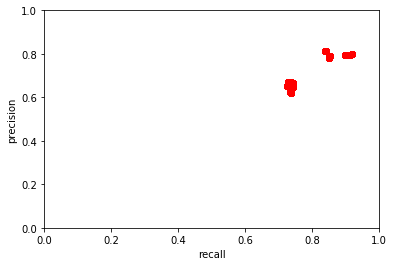

In [39]:
plt.plot(recall, precision, 'ro')
plt.xlabel('recall')
plt.ylabel('precision')
plt.axis([0, 1, 0, 1])
plt.show()

In [40]:
recall = []
precision = []
for i in result:
    recall.append(i[2].recall)
    precision.append(i[2].precision)

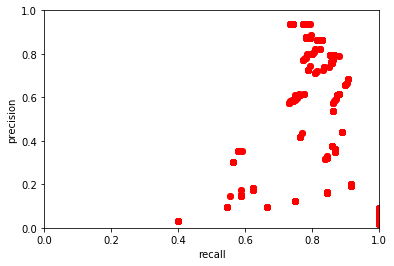

In [41]:
plt.plot(recall, precision, 'ro')
plt.xlabel('recall')
plt.ylabel('precision')
plt.axis([0, 1, 0, 1])
plt.show()

In [44]:
max(recall)

1.0

In [45]:
max(precision)

0.9354838709677419

In [51]:
for i in sorted(result, key =  lambda x: (x[1].recall, x[1].precision))[::-1][:50]:
    print(i[0])
    i[1].show()
    i[2].show()

{'angel': 40, 'cloud_min': 0.015, 'combine_minimun_distance': 0.039999999999999994, 'circling_distance': 0.045}
Total detection: 185
True  Positive : 171
False Positive : 43
True  Negative : 15
False Negative : 15
recall : 0.919355
precision : 0.799065

Total detection: 0
True  Positive : 1
False Positive : 61
True  Negative : 0
False Negative : 0
recall : 1.000000
precision : 0.016129

{'angel': 40, 'cloud_min': 0.015, 'combine_minimun_distance': 0.039999999999999994, 'circling_distance': 0.039999999999999994}
Total detection: 185
True  Positive : 171
False Positive : 43
True  Negative : 15
False Negative : 15
recall : 0.919355
precision : 0.799065

Total detection: 0
True  Positive : 2
False Positive : 60
True  Negative : 3
False Negative : 3
recall : 0.400000
precision : 0.032258

{'angel': 40, 'cloud_min': 0.015, 'combine_minimun_distance': 0.039999999999999994, 'circling_distance': 0.034999999999999996}
Total detection: 185
True  Positive : 171
False Positive : 43
True  Negative :

In [55]:
import pickle

In [56]:
import pickle
outputFile = 'test.data'
fw = open(outputFile, 'wb')
pickle.dump(result, fw)
fw.close()

In [60]:
import pickle
outputFile = 'test2.data'
fw = open(outputFile, 'wb')
pickle.dump(new_parameter_results, fw)
fw.close()

In [63]:
len(new_parameter_results)

1296

In [65]:
new_parameter_results[0][1]

In [66]:
recall = []
precision = []
for i in new_parameter_results:
    recall.append(i[1].recall)
    precision.append(i[1].precision)

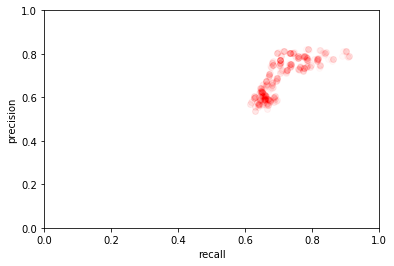

In [72]:
plt.plot(recall, precision, 'ro', alpha=0.01)
plt.xlabel('recall')
plt.ylabel('precision')
plt.axis([0, 1, 0, 1])
plt.show()

In [68]:
for i in sorted(new_parameter_results, key =  lambda x: (x[1].recall, x[1].precision))[::-1][:10]:
    print(i[0])
    i[1].show()
    i[2].show()

{'angel': 40, 'cloud_min': 0.015, 'combine_minimun_distance': 0.034999999999999996, 'analysis_image_kernal': array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8), 'cluster_threshold_': 30}
Total detection: 189
True  Positive : 171
False Positive : 46
True  Negative : 17
False Negative : 17
recall : 0.909574
precision : 0.788018

Total detection: 0
True  Positive : 51
False Positive : 10
True  Negative : 16
False Negative : 16
recall : 0.761194
precision : 0.836066

{'angel': 40, 'cloud_min': 0.015, 'combine_minimun_distance': 0.03, 'analysis_image_kernal': array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]], dtype=uint8), 'cluster_threshold_': 30}
Total detection: 189
True  Positive : 171
False Positive : 46
True  Negative : 17
False Negative : 17
recall : 0.909574
precision : 0.788018

Total detection: 0
True  Positive : 51
False Positive : 10
True  Negative : 16
False Negative : 16
recall : 0.761194
precision : 0.836066

{'angel': 40, 'cloud_min': 0.015, 'combine_min